# GAT-Net model
## A Residual Graph Attention Network for Floor Plan Analysis.

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GAT-Net model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
    </ul>
</ul>

<a id='intro'></a>
## Introduction

* In this notebook, we will implement the GAT-Net model for floor plan analysis and room size estimation.
* The model is trained on:
   * The graph version of the RPlan dataset.
     * The Image - Source version - of Rplan dataset is [here](http://staff.ustc.edu.cn/~fuxm/projects/DeepLayout/index.html)
     * The Graph version of RPlan dataset is created using the generating-graphs notebook. You can find it [here]()
   * Nvidia P100 GPU.
   * Core of the model is the Graph Attention Network (GAT) layers.

> The Graph version of RPlan dataset is created using the generating-graphs.ipynb notebook. **You can find it in the Creating_Data folder.**

<a id='Imports'></a>
### Imports

min_area num: 287
min_area range: min = -1.426190194973662 , max = 1.4091330962396587
min_area avg: 0.003820419671383892


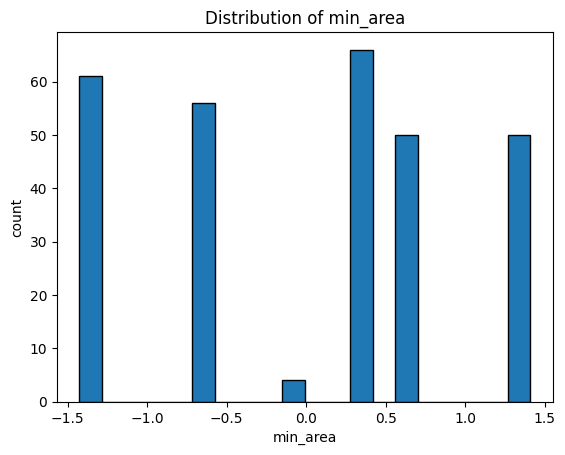

In [203]:
import pickle
import matplotlib.pyplot as plt

with open(r"C:/Users/jensonyu/Documents/ENGR project/Floor_Plan_Generation_using_GNNs-with-boundary/Creating_Dataset/graphs/Graphs_living_to_all_normalized.pkl", "rb") as f:
    dataset = pickle.load(f)

min_areas = []

for i, G in enumerate(dataset[:50]):  
    for node, attrs in G.nodes(data=True):
        if "min_area" in attrs:
            min_areas.append(attrs["min_area"])

print("min_area num:", len(min_areas))
print("min_area range: min =", min(min_areas), ", max =", max(min_areas))
print("min_area avg:", sum(min_areas)/len(min_areas))

plt.hist(min_areas, bins=20, edgecolor='black')
plt.title("Distribution of min_area")
plt.xlabel("min_area")
plt.ylabel("count")
plt.show()


In [204]:
# Only for kaggle
# !pip install torch_geometric

In [205]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [206]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# for my pc
url_living_to_all = r"C:/Users/jensonyu/Documents/ENGR project/Floor_Plan_Generation_using_GNNs-with-boundary/Creating_Dataset/graphs/Graphs_living_to_all_normalized.pkl"
url_boundary = r"C:/Users/jensonyu/Documents/ENGR project/Floor_Plan_Generation_using_GNNs-with-boundary/Creating_Dataset/graphs/boundaries.pkl"

# # for kaggle
# url_real = "/kaggle/input/planify-graphs-all-forms/graphs/Graphs_real.pkl"
# url_boundary = "/kaggle/input/planify-graphs-all-forms/graphs/boundaries.pkl"

<a id='func'></a>
### Functions used

In [207]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [208]:
def draw_graph_nodes(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')

    
    nx.draw_networkx_nodes(G, pos=pos, node_size=scales, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos, edge_color='b');
    nx.draw_networkx_labels(G, pos=pos, font_size=8);

    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    
    # # Drawing the graph inside a good boundary.
    # x_coords  = [pos[node][0] for node in pos]
    # y_coords  = [pos[node][1] for node in pos]
    # threshold = max(scales) / 100
    
    # plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    

def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    # nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos)
    
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    
    
# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')
    
    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()
        
        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()
        
        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph
            
        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
            min_y = min_y_in_graph
            
    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values


def get_all_x_y(graphs):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []
    for i, G in tqdm(enumerate(graphs), desc="getting all Xs, Ys", total=len(graphs)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())
            

    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()
    

def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');

<a id='wrangling'></a>
## Data wrangling


In [209]:
with open(url_living_to_all, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)

Graph with 8 nodes and 7 edges


> Considering boundaries

In [210]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)
    
b = boundaries[1911]
print(b)

Graph with 9 nodes and 9 edges


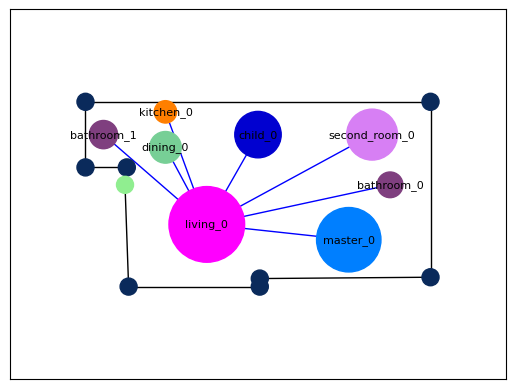

In [211]:
draw_graph_boundary(b)
draw_graph_nodes(G)

In [212]:
def convert_networkx_Graphs_to_pyTorchGraphs(G):
    """Converting networkx graphs to pytorchGeo graphs with min_area"""
    features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y', 'min_area']
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    return G_new

Graphs_pyTorch = list(map(convert_networkx_Graphs_to_pyTorchGraphs, Graphs))

Graphs_pyTorch[0]

Data(edge_index=[2, 10], roomType_name=[6], rec_w=[6], rec_h=[6], roomSize=[6], x=[6, 4], edge_attr=[10, 1])

In [213]:
def convert_networkx_Boundaries_to_pyTorchGraphs(b):
    """Converting networkx boundary graphs to PyTorchGeo graphs
    """
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    return b_new

Boundaries_pyTorch = list(map(convert_networkx_Boundaries_to_pyTorchGraphs, boundaries))

Boundaries_pyTorch[0]

Data(edge_index=[2, 26], x=[13, 3], edge_attr=[26, 1])

> Some statistics, To make normalization for x and y but to be able to get back to the real values

In [214]:
G_x, G_y = get_all_x_y(Graphs_pyTorch)
G_x.max(), G_y.max(), G_x.min(), G_y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:02<00:00, 29961.44it/s]


(234.5, 234.0, 20.0, 20.5)

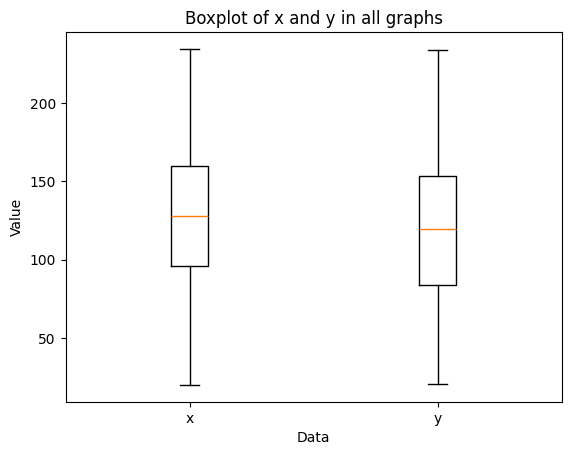

In [215]:
# making box plot for x and y for the graphs
boxplot_centrValues(G_x, G_y)

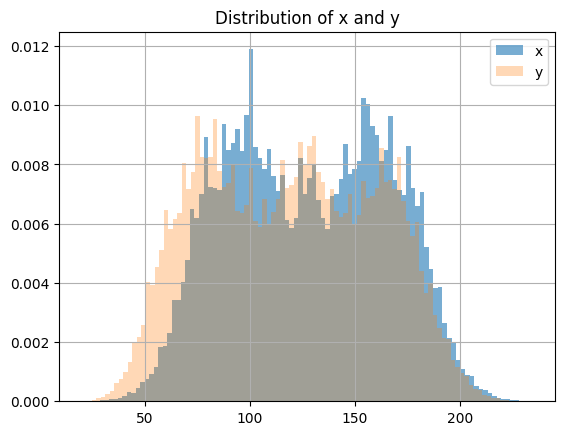

In [216]:
plot_histograms(G_x, G_y)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [217]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
G_x_mean = G_x.mean()
G_y_mean = G_y.mean()
G_x_std  = G_x.std()
G_y_std  = G_y.std()
# collect all min_area values
G_min_area = [G.x[:, 3].tolist() for G in Graphs_pyTorch]
G_min_area = pd.Series([item for sublist in G_min_area for item in sublist])

min_area_mean = G_min_area.mean()
min_area_std  = G_min_area.std()

print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [218]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722,   1.4091],
        [  1.0000, 181.5403, 165.1201,   0.7003],
        [  2.0000,  59.5000,  55.5000,  -0.7174],
        [  3.0000, 192.0000, 127.0000,  -1.4262],
        [  3.0000, 120.7426, 100.7954,  -1.4262],
        [  7.0000, 132.6687, 167.8575,   0.3459],
        [  7.0000, 152.0459, 100.5418,   0.3459]])


100%|██████████| 80787/80787 [00:02<00:00, 39309.66it/s]

After: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722,   1.4091],
        [  1.0000, 181.5403, 165.1201,   0.7003],
        [  2.0000,  59.5000,  55.5000,  -0.7174],
        [  3.0000, 192.0000, 127.0000,  -1.4262],
        [  3.0000, 120.7426, 100.7954,  -1.4262],
        [  1.0000, 132.6687, 167.8575,   0.3459],
        [  1.0000, 152.0459, 100.5418,   0.3459]])


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [219]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    # normalize x, y
    G.x[:, 1] = (G.x[:, 1] - G_x_mean) / G_x_std
    G.x[:, 2] = (G.x[:, 2] - G_y_mean) / G_y_std

    # normalize min_area
    G.x[:, 3] = (G.x[:, 3] - min_area_mean) / min_area_std

    # one-hot encoding of room type
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)

    # concat: [one-hot room type] + [normalized x, y, min_area]
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)


100%|██████████| 80787/80787 [00:05<00:00, 14780.51it/s]


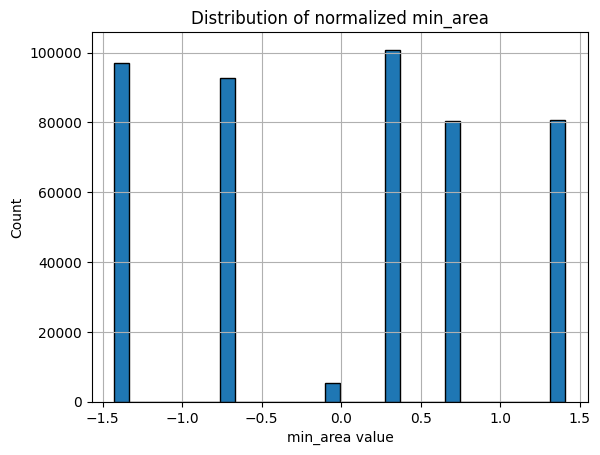

In [220]:
import matplotlib.pyplot as plt

min_areas = [G.x[:, -1].tolist() for G in Graphs_pyTorch] 
min_areas = [val for sublist in min_areas for val in sublist]  # flatten

plt.hist(min_areas, bins=30, edgecolor='black')
plt.title("Distribution of normalized min_area")
plt.xlabel("min_area value")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [221]:
import json

min_area_stats = {
    "mean": min_area_mean.item() if hasattr(min_area_mean, "item") else float(min_area_mean),
    "std": min_area_std.item() if hasattr(min_area_std, "item") else float(min_area_std)
}

with open("min_area_stats.json", "w") as f:
    json.dump(min_area_stats, f)

print("min_area_stats.json saved")


min_area_stats.json saved


In [222]:
return_to_real = Graphs_pyTorch[1].x[:, [-3, -2]] * torch.tensor([G_x_std, G_y_std]) + torch.Tensor([G_x_mean, G_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")

Now, we could return back to real values: 
tensor([[ 81.9371, 137.1722],
        [181.5403, 165.1201],
        [ 59.5000,  55.5000],
        [192.0000, 127.0000],
        [120.7426, 100.7954],
        [132.6687, 167.8575],
        [152.0459, 100.5418]])


> Normalizing the centroid of the boundaries

In [223]:
B_x, B_y = get_all_x_y(Boundaries_pyTorch)
B_x.max(), B_y.max(), B_x.min(), B_y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:05<00:00, 14047.90it/s]


(245.0, 244.0, 12.0, 11.0)

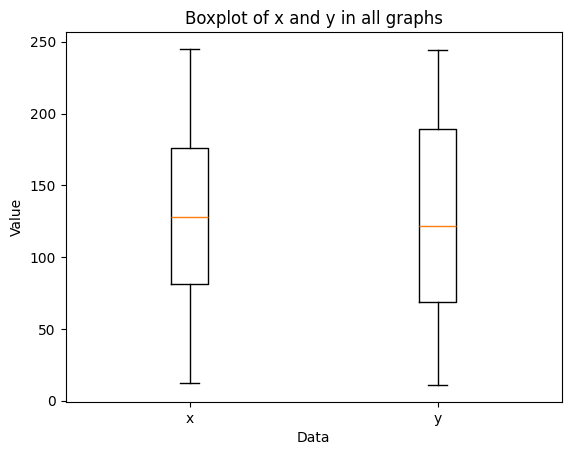

In [224]:
boxplot_centrValues(B_x, B_y)

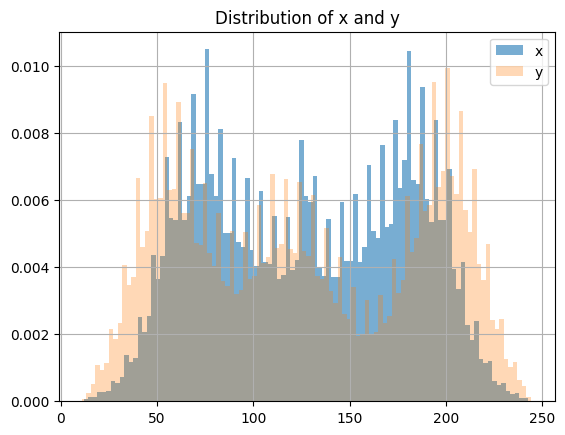

In [225]:
plot_histograms(B_x, B_y)

> And we saw the box plots so there is no outliers.
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [226]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
B_x_mean = B_x.mean()
B_y_mean = B_y.mean()
B_x_std  = B_x.std()
B_y_std  = B_y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [227]:
for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):
    
    # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
    # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly 
    # multiply the means using the idea of "Broadcasting".
    b.x[:, 1:] = (b.x[:, 1:] - torch.tensor([B_x_mean, B_y_mean])) / torch.tensor([B_x_std, B_y_std])

100%|██████████| 80787/80787 [00:01<00:00, 53902.30it/s]


In [228]:
return_to_real = Boundaries_pyTorch[1].x[:, [-2, -1]] * torch.tensor([B_x_std, B_y_std]) + torch.Tensor([B_x_mean, B_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")

Now, we could return back to real values: 
tensor([[ 48.0000,  36.0000],
        [ 48.0000, 220.0000],
        [106.0000, 220.0000],
        [106.0000, 196.0000],
        [208.0000, 195.0000],
        [208.0000, 117.0000],
        [172.0000, 117.0000],
        [171.0000,  81.0000],
        [ 72.0000,  81.0000],
        [ 71.0000,  36.0000],
        [100.0000,  78.0000]], dtype=torch.float64)


> If we need to creat graphs with padding by the maximum number of nodes.

In [229]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [230]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(self.device)
        B = self.Boundaries[index].clone().to(self.device)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)
        
        # shuffling nodes inside the same graph
        # permutation = torch.randperm(G.num_nodes).to(self.device)
        
        # G.x = G.x[permutation]
        # G.edge_index = permutation[G.edge_index]
        # G.rec_w = G.rec_w[permutation]
        # G.rec_h = G.rec_h[permutation]
        # G.edge_attr = G.edge_attr[permutation]
        
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        graphs = {
            'G': G,
            'B': B
        }
        
        return graphs

In [231]:
edge = int(len(Graphs_pyTorch) * 0.8)

In [232]:
batch_size = 32
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10], Boundaries_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:], Boundaries_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"Train dataset: {len(train_dataset)}, Val dataset: {len(val_dataset)}, Test dataset: {len(test_dataset)}")

Train dataset: 64629, Val dataset: 16148, Test dataset: 10


In [233]:
# Saving model function
import os

checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'Best_model_v4.pt')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)
    
    print('Model saved :)')

<a id='archi'></a>
### Architecture

In [234]:
class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        
        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)
        
        input_of_conv2   = num_graph_node_features + 32*4
        self.graph_conv2 = GATConv(input_of_conv2, 32, heads=8)
        
        input_of_conv3   = num_graph_node_features + 32*8
        self.graph_conv3 = GATConv(input_of_conv3, 64, heads=8)
        
        input_of_conv4   = num_graph_node_features + 64*8
        self.graph_conv4 = GATConv(input_of_conv4, 128, heads=8)
        # self.graph_conv5 = GATConv(128*8, 128, heads=8)
        # self.graph_conv6 = GATConv(128*8, 128, heads=16)
        # self.graph_conv7 = GATConv(128*16, 256, heads=16)
        # self.graph_conv8 = GATConv(256*16, 256, heads=16)
        shape_of_graphs_befor_concatination = num_graph_node_features + 128*8
        
        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)
        input_of_boundary_conv2 = 32*4 + num_boundary_node_features
        self.boundary_conv2 = GATConv(input_of_boundary_conv2, 32, heads=8)
        # self.boundary_conv3 = GATConv(32*8, 64, heads=8)
        # self.boundary_conv4 = GATConv(64*8, 128, heads=8)
        # self.boundary_conv5 = GATConv(128*8, 128, heads=8)
        shape_of_boundary_befor_concatination = num_boundary_node_features + 32 * 8
        
        # Output of graph_conv8 + output of boundary_conv5 + 2 step connection from real nodes and boundary nodes
        inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
        self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)
        # self.Concatination2  = GATConv(128*8, 64, heads=8)
        # self.Concatination3  = GATConv(64*8, 64, heads=8)
        # self.Concatination4  = GATConv(64*8, 32, heads=8)
        # self.Concatination5  = GATConv(32*8, 32*4)
        
        # self.lin1 = nn.Linear(inputs_concatination, 256)
        # self.lin2 = nn.Linear(256, 32)

        self.width_layer1  = nn.Linear(128*8, 128)
        self.height_layer1 = nn.Linear(128*8, 128)
        
        # self.width_layer2  = nn.Linear(256, 128)
        # self.height_layer2 = nn.Linear(256, 128)
        
        # self.width_layer3  = nn.Linear(128, 32)
        # self.height_layer3 = nn.Linear(128, 32)
        
        # self.width_layer4  = nn.Linear(32, 8)
        # self.height_layer4 = nn.Linear(32, 8)
        
        self.width_output  = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)
        
        
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr, g_batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch
        
        NUM_OF_NODES = x_graph.shape[0]
        # During testing, as we input only one graph.
        if g_batch == None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if b_batch == None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        
        x_graph_res = x_graph
        x_boundary_res = x_boundary
        
        # Passing the graph throught a message passing to embed its features
        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph) # Concatinate with step connection from real values.
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        
        x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        # x_graph = F.leaky_relu(self.graph_conv5(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv6(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)
        # x_graph = F.leaky_relu(self.graph_conv7(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv8(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)
        
        
        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
        x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
        # x_boundary = F.leaky_relu(self.boundary_conv3(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)
        # x_boundary = F.leaky_relu(self.boundary_conv4(x_boundary, b_edge_indexy))
        # x_boundary = F.leaky_relu(self.boundary_conv5(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)

        # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination2(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination3(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination4(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination5(x, g_edge_index))
        # x = self.dropout(x)
        
        # x = F.leaky_relu(self.lin1(x))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.lin2(x))
        # x = self.dropout(x)
        
        
        width = F.leaky_relu(self.width_layer1(x))
        # width = F.leaky_relu(self.width_layer2(width))
        # width = F.leaky_relu(self.width_layer3(width))
        # width = F.leaky_relu(self.width_layer4(width))
        width = self.dropout(width)
        width = self.width_output(width)
        
        height = F.leaky_relu(self.height_layer1(x))
        # height = F.leaky_relu(self.height_layer2(height))
        # height = F.leaky_relu(self.height_layer3(height))
        # height = F.leaky_relu(self.height_layer4(height))
        height = self.dropout(height)
        height = self.height_output(height)
        
        return width.squeeze(), height.squeeze()

num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]
print("Graph node feature dim:", num_graph_node_features)
print("Boundary node feature dim:", num_boundary_node_features)

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

Graph node feature dim: 10
Boundary node feature dim: 3


GATNet(
  (graph_conv1): GATConv(10, 32, heads=4)
  (graph_conv2): GATConv(138, 32, heads=8)
  (graph_conv3): GATConv(266, 64, heads=8)
  (graph_conv4): GATConv(522, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1293, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [235]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        graph, boundary = data['G'], data['B']
        
        width, height    = model(graph, boundary)
        
        width_loss = criterion(width, graph.rec_w)
        height_loss = criterion(height, graph.rec_h)

        loss = width_loss + height_loss

        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            graph, boundary = data['G'], data['B']
            width, height    = model(graph, boundary)
            width_loss = criterion(width, graph.rec_w)
            height_loss = criterion(height, graph.rec_h)

            loss = width_loss + height_loss
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

In [236]:
from copy import deepcopy

# Hyperparameters
learning_rate = 0.0005
num_epochs = 250
patience = 10 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')

counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)

# Notice
train_losses = []
val_losses = []


<a id='train'></a>
### Training


In [237]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
     
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

Validating ...
Epoch [1/250], Train Loss: 622.1475, Validation Loss: 354.4361
Model saved :)
Validating ...
Epoch [2/250], Train Loss: 283.0320, Validation Loss: 360.4797
Validating ...
Epoch [3/250], Train Loss: 247.7465, Validation Loss: 391.6334
Learning rate decreased!, now is 0.000475
Validating ...
Epoch [4/250], Train Loss: 229.8109, Validation Loss: 334.6419
Model saved :)
Validating ...
Epoch [5/250], Train Loss: 219.0481, Validation Loss: 303.2863
Model saved :)
Validating ...
Epoch [6/250], Train Loss: 211.4654, Validation Loss: 250.2382
Model saved :)
Validating ...
Epoch [7/250], Train Loss: 205.3283, Validation Loss: 258.8395
Validating ...
Epoch [8/250], Train Loss: 200.1264, Validation Loss: 235.4422
Model saved :)
Validating ...
Epoch [9/250], Train Loss: 195.3210, Validation Loss: 239.3479
Validating ...
Epoch [10/250], Train Loss: 191.9040, Validation Loss: 258.8887
Learning rate decreased!, now is 0.00045125
Validating ...
Epoch [11/250], Train Loss: 187.8720, Valid

In [238]:
# def save_checkpoint(model, optimizer, epoch, suffix=""):
#     filename = f'Best_model_V3{suffix}.pt' if suffix else 'Best_model_V3.pt'
#     checkpoint_path = os.path.join(checkpoint_dir, filename)
    
#     torch.save({
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'epoch': epoch
#     }, checkpoint_path)
    
#     print(f'Model saved to {filename} :)')

In [239]:
# # run this if you have bunch of time (over 12 hours lmao)
# # this section tests diff parameters and see which one is the best set
# from copy import deepcopy
# import itertools

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# learning_rates = [1e-3, 5e-4, 1e-4]
# weight_decays = [0, 1e-5, 3e-5]
# gammas = [0.98, 0.95]

# num_epochs = 250
# patience = 10

# results = []

# for lr, wd, gamma in itertools.product(learning_rates, weight_decays, gammas):
#     print(f"\n===== Training with lr={lr}, weight_decay={wd}, gamma={gamma} =====")

#     model = GATNet(num_graph_node_features, num_boundary_node_features).to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
#     criterion = nn.MSELoss()

#     best_val_loss = float('inf')
#     counter = 0
#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         train_loss = train(model, optimizer, criterion, train_loader)
#         train_losses.append(train_loss)

#         val_loss = evaluate(model, criterion, val_loader)
#         val_losses.append(val_loss)

#         print(f'Epoch [{epoch+1}/{num_epochs}] | Train: {train_loss:.4f} | Val: {val_loss:.4f}')

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model = deepcopy(model)
#             save_checkpoint(best_model, optimizer, epoch, suffix=f'lr{lr}_wd{wd}_gamma{gamma}')
#             counter = 0
#         else:
#             counter += 1
#             if counter >= patience:
#                 print(f"Early stopping triggered at epoch {epoch+1}")
#                 break
#             if counter in range(2, 20, 2):
#                 scheduler.step()
#                 print(f"Learning rate decreased! Now: {optimizer.state_dict()['param_groups'][0]['lr']}")

#     results.append({
#         'lr': lr,
#         'weight_decay': wd,
#         'gamma': gamma,
#         'best_val_loss': best_val_loss,
#         'train_losses': train_losses,
#         'val_losses': val_losses
#     })

# # summary
# print("\n========== Summary ==========")
# results.sort(key=lambda x: x['best_val_loss'])
# for i, res in enumerate(results):
#     print(f"{i+1}. lr={res['lr']}, wd={res['weight_decay']}, gamma={res['gamma']}, best_val_loss={res['best_val_loss']:.4f}")


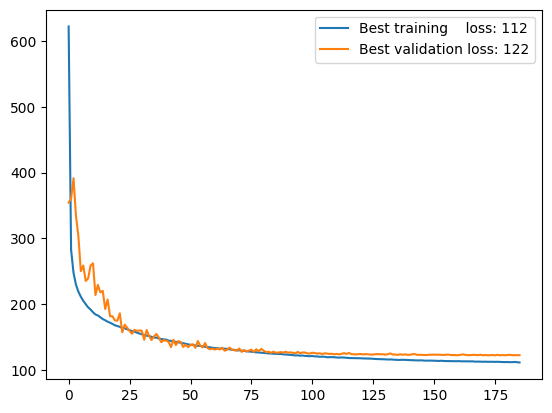

In [240]:
plt.plot(train_losses, label=f'Best training    loss: {min(train_losses):.0f}');
plt.plot(val_losses, label=f'Best validation loss: {min(val_losses):.0f}');
plt.legend();